In [58]:
# Data manipulation
import pandas as pd
import numpy as np
import time
import pickle

# Plotting
import matplotlib
import matplotlib.pyplot as plt

# strava API access
from stravalib.client import Client

In [20]:
# read API credentials
with open('./aicoach/client.secret', 'r') as file:
    MY_STRAVA_CLIENT_ID, MY_STRAVA_CLIENT_SECRET = file.read().strip().split(',')
print(MY_STRAVA_CLIENT_ID)
print(MY_STRAVA_CLIENT_SECRET)

112785
445b52b44be044a638dc92c66ca25d8e6c972cda


In [25]:
# generate access URL
client = Client()
url = client.authorization_url(client_id=MY_STRAVA_CLIENT_ID, redirect_uri='http://127.0.0.1:5000/authorization', scope=['read_all','profile:read_all','activity:read_all'])

In [26]:
print(url)

https://www.strava.com/oauth/authorize?client_id=112785&redirect_uri=http%3A%2F%2F127.0.0.1%3A5000%2Fauthorization&approval_prompt=auto&scope=read_all%2Cprofile%3Aread_all%2Cactivity%3Aread_all&response_type=code


In [30]:
# generate access token and store to pickle
CODE='1b8f7c2ee73882c05f996797464be7700482a11c'
access_token = client.exchange_code_for_token(client_id=MY_STRAVA_CLIENT_ID, client_secret=MY_STRAVA_CLIENT_SECRET, code=CODE)
with open('./aicoach/access_token.pickle', 'wb') as f:
    pickle.dump(access_token, f)

In [31]:
# open access token
with open('./aicoach/access_token.pickle', 'rb') as f:
    access_token = pickle.load(f)
    
print('Latest access token read from file:')
access_token

Latest access token read from file:


{'access_token': '9243bf9ff4fcb548e7a7cef5b8216ed6a8dd97d2',
 'refresh_token': '407037c110befc81b79fca4edb1a27f0332df861',
 'expires_at': 1693179287}

In [69]:
if time.time() > access_token['expires_at']:
    print('Token has expired, will refresh')
    refresh_response = client.refresh_access_token(client_id=MY_STRAVA_CLIENT_ID, client_secret=MY_STRAVA_CLIENT_SECRET, refresh_token=access_token['refresh_token'])
    access_token = refresh_response
    with open('../access_token.pickle', 'wb') as f:
        pickle.dump(refresh_response, f)
    print('Refreshed token saved to file')
    client.access_token = refresh_response['access_token']
    client.refresh_token = refresh_response['refresh_token']
    client.token_expires_at = refresh_response['expires_at']
        
else:
    print('Token still valid, expires at {}'
          .format(time.strftime("%a, %d %b %Y %H:%M:%S %Z", time.localtime(access_token['expires_at']))))
    client.access_token = access_token['access_token']
    client.refresh_token = access_token['refresh_token']
    client.token_expires_at = access_token['expires_at']

Token still valid, expires at Mon, 28 Aug 2023 14:35:45 +03


In [35]:
# check athlete
athlete = client.get_athlete()
print("Athlete's name is {} {}, based in {}, {}"
      .format(athlete.firstname, athlete.lastname, athlete.city, athlete.country))

Athlete's name is Pavel Golikov, based in Москва, Russia


In [70]:
activities = client.get_activities(limit=1000)
# list(activities)[0:5]

In [112]:
# Look at one activity to get a view of what's available

sample = list(activities)[0]
sample.to_dict()

{'id': 9734281287,
 'achievement_count': 3,
 'athlete': {'id': 6944270,
  'city': None,
  'country': None,
  'created_at': None,
  'firstname': None,
  'lastname': None,
  'premium': None,
  'profile': None,
  'profile_medium': None,
  'resource_state': 1,
  'sex': None,
  'state': None,
  'summit': None,
  'updated_at': None,
  'bikes': None,
  'clubs': None,
  'follower_count': None,
  'friend_count': None,
  'ftp': None,
  'measurement_preference': None,
  'shoes': None,
  'weight': None,
  'is_authenticated': None,
  'athlete_type': None,
  'friend': None,
  'follower': None,
  'approve_followers': None,
  'badge_type_id': None,
  'mutual_friend_count': None,
  'date_preference': None,
  'email': None,
  'super_user': None,
  'email_language': None,
  'max_heartrate': None,
  'username': None,
  'description': None,
  'instagram_username': None,
  'offer_in_app_payment': None,
  'global_privacy': None,
  'receive_newsletter': None,
  'email_kom_lost': None,
  'dateofbirth': None,
 

In [113]:
my_cols =['name',
          'start_date_local',
          'type',
          'distance',
          'moving_time',
          'elapsed_time',
          'total_elevation_gain',
          'elev_high',
          'elev_low',
          'average_speed',
          'max_speed',
          'average_watts',
          'weighted_average_watts',
          'max_watts',
          'has_heartrate',
          'average_heartrate',
          'max_heartrate',
          'suffer_score',
          'average_temp',
          'start_latlng',
          'end_latlng']

In [114]:
data = []
for activity in activities:
    my_dict = activity.to_dict()
    data.append([activity.id]+[my_dict.get(x) for x in my_cols])
    
# Add id to the beginning of the columns, used when selecting a specific activity
my_cols.insert(0,'id')

In [115]:
df = pd.DataFrame(data, columns=my_cols)
df.head(5)

,id,name,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,...,average_watts,weighted_average_watts,max_watts,has_heartrate,average_heartrate,max_heartrate,suffer_score,average_temp,start_latlng,end_latlng
0,9734281287,Morning Ride,2023-08-28 04:50:25,Ride,46936.5,5175,5477,115.0,83.8,-84.0,...,194.6,226.0,845.0,True,124.9,164.0,30.0,29.0,"[26.283474499359727, 50.1107909437269]","[26.28418662585318, 50.11045642197132]"
1,9731353666,Afternoon Run,2023-08-27 17:15:46,Run,6446.4,2132,2242,35.0,69.4,38.2,...,NaN,NaN,NaN,True,126.2,137.0,7.0,34.0,"[26.28420070745051, 50.11035634204745]","[26.284309588372707, 50.11032583191991]"
2,9727909693,Morning Swim,2023-08-27 05:52:03,Swim,2500.0,2914,3302,0.0,0.0,0.0,...,NaN,NaN,NaN,True,103.8,123.0,8.0,NaN,None,None
3,9721484682,Morning Run,2023-08-26 05:26:43,Run,18743.1,5830,6630,120.0,94.2,25.4,...,NaN,NaN,NaN,True,137.9,170.0,50.0,31.0,"[26.284196181222796, 50.11045407503843]","[26.284269355237484, 50.11032549664378]"
4,9715924868,Big city vibe😎,2023-08-25 04:46:07,Ride,100843.0,10497,11865,379.0,37.4,-169.6,...,174.2,194.0,816.0,True,123.1,161.0,55.0,37.0,"[26.36645936407149, 50.20594750531018]","[26.365674985572696, 50.20624137483537]"


In [116]:
df.tail(5)

,id,name,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,...,average_watts,weighted_average_watts,max_watts,has_heartrate,average_heartrate,max_heartrate,suffer_score,average_temp,start_latlng,end_latlng
995,5767099768,Wet and muddy ride,2021-08-10 07:49:16,Ride,80019.8,10081,10592,468.0,333.0,186.8,...,241.4,NaN,NaN,True,122.8,157.0,37.0,21.0,"[54.218729, 83.397048]","[54.2187, 83.395329]"
996,5761848271,Morning Run,2021-08-09 08:37:07,Run,23117.9,6959,7898,157.0,178.0,107.8,...,NaN,NaN,NaN,True,140.4,172.0,55.0,24.0,"[55.029007, 82.905841]","[55.029207, 82.90584]"
997,5751021419,Morning Run,2021-08-07 10:08:07,Run,17222.1,5431,5857,83.0,284.6,263.0,...,NaN,NaN,NaN,True,129.3,152.0,21.0,21.0,"[54.218845, 83.3955]","[54.21868, 83.39596]"
998,5746258151,Morning Run,2021-08-06 10:05:22,Run,12295.6,3601,3601,36.0,287.2,268.6,...,NaN,NaN,NaN,True,136.1,168.0,21.0,21.0,"[54.218814, 83.395555]","[54.218798, 83.395594]"
999,5740792056,Morning Run,2021-08-05 08:07:49,Run,11060.8,3613,3623,30.0,285.0,268.6,...,NaN,NaN,NaN,True,131.2,145.0,14.0,21.0,"[54.218855, 83.395655]","[54.21894, 83.396187]"


In [117]:
# check what types of activities were recorded
activities_types = df['type'].unique()
print(activities_types)

['Ride' 'Run' 'Swim' 'VirtualRide' 'VirtualRun' 'StandUpPaddling' 'Hike'
 'WeightTraining' 'NordicSki']


In [84]:
# get example of data for one activity
activity_number = 0
types = ['time', 'distance', 'latlng', 'altitude', 'velocity_smooth', 'moving', 'grade_smooth','heartrate', 'cadence', 'watts', 'temp']
activity_data=client.get_activity_streams(df['id'][activity_number],types = types)

In [85]:
activity_data.keys()

dict_keys(['temp', 'watts', 'moving', 'latlng', 'velocity_smooth', 'grade_smooth', 'cadence', 'distance', 'heartrate', 'altitude', 'time'])

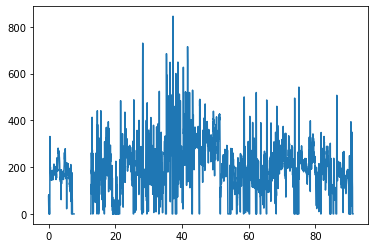

In [87]:
fig = plt.figure()
plt.plot(np.array(activity_data['time'].data)/60,np.array(activity_data['watts'].data))

In [136]:
# NP calc test
w = np.array(activity_data['watts'].data
#def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
             
def calc_np(w):
    normp = np.average(np.power(np.power(moving_average(w, 30), 4),0.25))
    return normp

SyntaxError: invalid syntax (<ipython-input-136-a35f822c8a15>, line 4)

In [137]:
# NP calc test
w = np.array(activity_data['watts'].data

def moving_average(x,w):
    return np.convolve(x, np.ones(w), 'valid') / w

SyntaxError: invalid syntax (<ipython-input-137-07a8105f3419>, line 4)

In [132]:
print(df['elapsed_time'].iloc[0])
print(len(activity_data['watts'].data))
print(activity_data['time'].data[-1])

5477
5177
5477


## Cycling data analysis

In [124]:
# select all Ride and VirtualRide activities
br = df[(df['type']=='Ride') | (df['type']=='VirtualRide')]
bvr = df[df['type']=='VirtualRide']
print(len(df),len(br),len(bvr))
# remove activities without power recorded
br = br.dropna(subset=['weighted_average_watts'])
print(len(br))

1000 349 133
309


In [125]:
br.head(20)

,id,name,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,...,average_watts,weighted_average_watts,max_watts,has_heartrate,average_heartrate,max_heartrate,suffer_score,average_temp,start_latlng,end_latlng
0,9734281287,Morning Ride,2023-08-28 04:50:25,Ride,46936.5,5175,5477,115.0,83.8,-84.0,...,194.6,226.0,845.0,True,124.9,164.0,30.0,29.0,"[26.283474499359727, 50.1107909437269]","[26.28418662585318, 50.11045642197132]"
4,9715924868,Big city vibe😎,2023-08-25 04:46:07,Ride,100843.0,10497,11865,379.0,37.4,-169.6,...,174.2,194.0,816.0,True,123.1,161.0,55.0,37.0,"[26.36645936407149, 50.20594750531018]","[26.365674985572696, 50.20624137483537]"
7,9702692814,Zwift - Chris Beyers' Meetup on Tempus Fugit i...,2023-08-23 05:00:00,VirtualRide,47981.5,4527,4527,72.0,17.6,12.4,...,246.4,274.0,943.0,True,136.3,174.0,38.0,NaN,"[-11.637096488848329, 166.97112386114895]","[-11.64923214353621, 166.9940816424787]"
10,9692166213,Zwift - Intervals 75/75+ tempo in Watopia,2023-08-21 16:50:53,VirtualRide,46765.8,4545,4545,140.0,28.0,-6.4,...,241.0,256.0,383.0,True,118.2,136.0,14.0,NaN,"[-11.636653589084744, 166.97231057099998]","[-11.653381437063217, 166.96540279313922]"
15,9670365692,Morning Ride,2023-08-18 04:52:02,Ride,100402.0,11554,14511,436.0,99.6,-263.4,...,187.2,207.0,680.0,True,140.2,170.0,126.0,36.0,"[26.283208038657904, 50.11220312677324]","[26.284228703007102, 50.11043773032725]"
18,9660010717,Zwift - 5. Long VO2 max in Watopia,2023-08-16 17:11:16,VirtualRide,46277.6,4518,4518,71.0,17.6,12.6,...,235.1,265.0,385.0,True,124.5,151.0,22.0,NaN,"[-11.636307584121823, 166.9724829029292]","[-11.65431727655232, 166.98562991805375]"
21,9643173899,Zwift - 10 min broken intervals in Watopia,2023-08-14 05:43:58,VirtualRide,39987.0,3921,3982,58.0,17.6,12.6,...,243.0,261.0,400.0,True,127.7,156.0,22.0,NaN,"[-11.637106379494071, 166.97149828076363]","[-11.645979881286621, 167.00059982948005]"
26,9624053795,Morning Ride,2023-08-11 04:50:01,Ride,79103.2,9176,11218,447.0,116.2,16.0,...,190.6,209.0,777.0,True,134.2,161.0,66.0,33.0,"[26.283182809129357, 50.11208645068109]","[26.284219482913613, 50.11047796346247]"
29,9610485218,Vacation mode emergency termination with WW🥵,2023-08-09 04:44:32,Ride,45482.0,4867,5393,262.0,110.0,23.8,...,215.6,245.0,797.0,True,145.8,176.0,70.0,31.0,"[26.28342387266457, 50.10874534025788]","[26.284217052161694, 50.11044418439269]"
32,9597841258,Zwift - 60sec stair in Watopia,2023-08-07 08:15:47,VirtualRide,45333.6,4547,4547,138.0,28.0,-6.4,...,230.9,243.0,336.0,True,125.6,140.0,16.0,NaN,"[-11.636884259060025, 166.97203614749014]","[-11.658115116879344, 166.97374580428004]"


In [127]:
br['id'].iloc[0]

9734281287

<AxesSubplot:xlabel='moving_time', ylabel='weighted_average_watts'>

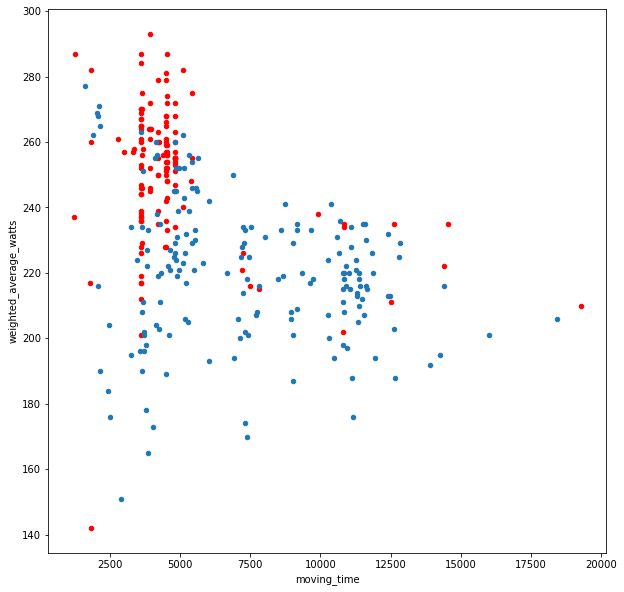

In [107]:
ax = bvr.plot.scatter(x='moving_time',y='weighted_average_watts',figsize=(10,10),color='r')
br.plot.scatter(x='moving_time',y='weighted_average_watts',ax=ax)

In [ ]:
# calculate peak powers
def pow_peak_calc()